# Actively learned model for an ensemble of heteroscedastic regression with offline query comparison to baseline.


In [1]:
import sys 
sys.path.append("../../")

%matplotlib inline

In [2]:
from uq360.algorithms.actively_learned_model import ActivelyLearnedModel
from uq360.algorithms.ensemble_heteroscedastic_regression import EnsembleHeteroscedasticRegression
from uq360.metrics import picp, mpiw, compute_regression_metrics
from uq360.metrics import UncertaintyCharacteristicsCurve as ucc

In [3]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

# Dataset (offline)

Based on Pestourie, R., Mroueh, Y., Nguyen, T. V., Das, P., & Johnson, S. G. (2020). Active learning of deep surrogates for PDEs: application to metasurface design. npj Computational Materials, 6(1), 1-7. We use supervised learning to train a surrogate model that, given the parameters of an already defined geometry parameterization, will predict the complex transmission above the geometry. This type of surrogate model is very useful in the context of decomposition methods, where the computational domain of a large-scale simulation is broken down into smaller pieces with same geometry parameterization and boundary conditions. In the case of Maxwell's equation, where the smaller problems have periodic boundary conditions with a period smaller than the wavelength, then the far-field above the geometry can be fully summarized by a single complex number--the complex transmission, which is obtained by solving an expensive PDE.

In order to alleviate that, we build a dataset, which consists of inputs to the surrogate model (10 inputs for the definition of the geometry, and 3 inputs for the one hot encoding of 3 frequencies) and their corresponding complex transmission (a single complex number). In this example, we train a surrogate model of the PDE solver to predict the real part of the complex transmission, using the least amount of data possible owing to an uncertainty quantification method available in uq360. This enables us to train the surrogate in an active learning fashion.

In [4]:
# Create a database with pores data
dataset = "data_realpart_complextransmission.csv"
data_pd = pd.read_csv(dataset)

X_data = data_pd.iloc[:, :-1].values
y_labels = np.squeeze(data_pd.iloc[:, -1:].values, axis=1)
y_labels = y_labels.reshape((-1,1))

In [5]:
''' 
    Offline sample and querry, two mandatory arguments (and the data):
    - Position where to start sampling
    - Number of points to sample
'''
def sample_(start_index, n_points, X_data=X_data):
    return X_data[start_index:start_index+n_points,:]

def querry_(start_index, n_points, y_labels=y_labels):
    return y_labels[start_index:start_index+n_points]

NB: for online application, the sample_ function is sampling at random, and the querry_ performs the online data exploration.

# Surrogate model

The model is an ensemble of heteroskedastic regressions.
Where each heteroskedastic regression is trained via optimizing a negative Gaussian loglikelihood where the mean $\mu(p)$ and the variance $\sigma(p)$ both depend on the input of the surrogate model $p$:

$$-\sum_p \log p_\Theta (y|p) \propto \sum_p \left[ \log \sigma(p) + \frac{(y(p)-\mu(p))^2}{2\sigma(p)^2} \right]$$

where $\Theta$ are the parameters of the neural network.

The mean and variance of the ensemble are the pooled mean $\mu_* = \frac{1}{J} \sum_i \mu_i(p)$ and variance $\sigma^2_*(p) = \frac{1}{J}\sum_i(\sigma_i^2(p)+(\mu_i^2(p)-\mu_*^2(p)))$, where $J$ is the number of models in the ensemble and $i$ is the index of the model in the ensemble.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define config for Heteroscedastic regression
config_HR = {"num_features": 13, "num_hidden": 64, "num_outputs": 1, "batch_size": 16, "num_epochs": 10,
                  "lr": 0.001}
HR_kwargs = {"model_type":'mlp',
               "config": config_HR,
               "device": device}
# define config for ensemble
config_ensemble = {"num_models": 1, 
          "batch_size": 16,
          "model_kwargs":HR_kwargs, }

ninit = 128
T = 8
# define config for active learning object
config_AL = {"num_init": 512, 
 "T": 8, 
 "K": 64, 
 "M": 4, 
 "sampling_function": sample_, 
 "querry_function" : querry_,
 "model_function": EnsembleHeteroscedasticRegression,
 "model_kwargs": {"model_type":'ensembleheteroscedasticregression', 
                                             "config":config_ensemble, 
                                             "device":device}, }

In [7]:
# Verify that the data set has the good dimension
assert(X_data.shape[0] >= config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"])
assert(X_data.shape[1] == config_HR["num_features"])


In [8]:
# Baseline without AL
K_train_list = [16, 32, 64, 128, 256, 512]
frac_err_baseline = []
N_test = 512

for i in range(len(K_train_list)):
    
    # Update dictiorary to have no active learning and the correct amount of points
    config_AL["model_kwargs"]["config"]["num_models"] = 5
    config_AL["num_init"] = ninit + K_train_list[i] * T
    config_AL["T"] = 0

    # Instantiate the class object and train the model
    uq_model = ActivelyLearnedModel(config=config_AL, device=device, online=False)
    uq_model = uq_model.fit()

    # Create a test dataset
    X_test = sample_(int(config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"]), int(N_test))
    y_test = querry_(int(config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"]), int(N_test))
    y_test = np.reshape(y_test, (-1,))

    res = uq_model.predict(X_test)
    y_test_pred = np.squeeze(res.y_mean, axis=1)
    
    frac_err_baseline.append(np.sqrt(np.sum(np.square(y_test - y_test_pred)))/np.sqrt(np.sum(np.square(y_test))))


Training model 0

Epoch: 0, loss = 1.1742808148264885
Epoch: 1, loss = 1.142091229557991
Epoch: 2, loss = 1.118767850100994
Epoch: 3, loss = 1.0984802544116974
Epoch: 4, loss = 1.0818207897245884
Epoch: 5, loss = 1.0679391659796238
Epoch: 6, loss = 1.0568950548768044
Epoch: 7, loss = 1.0479964725673199
Epoch: 8, loss = 1.0408768765628338
Epoch: 9, loss = 1.034744057804346

Training model 1

Epoch: 0, loss = 1.1637066453695297
Epoch: 1, loss = 1.132659401744604
Epoch: 2, loss = 1.1075685657560825
Epoch: 3, loss = 1.086596217006445
Epoch: 4, loss = 1.068942453712225
Epoch: 5, loss = 1.0536361299455166
Epoch: 6, loss = 1.041418381035328
Epoch: 7, loss = 1.0325183384120464
Epoch: 8, loss = 1.0242810398340225
Epoch: 9, loss = 1.0162724517285824

Training model 2

Epoch: 0, loss = 1.1736429333686829
Epoch: 1, loss = 1.1317177042365074
Epoch: 2, loss = 1.1047362796962261
Epoch: 3, loss = 1.082258515059948
Epoch: 4, loss = 1.065674889832735
Epoch: 5, loss = 1.0534808672964573
Epoch: 6, loss =

# Active learning

The active learning algorithm is a potential solution to the exploration exploitation trade-off. Instead of exploring the input space at random. The active learning algorithm explores only the $K$ points $p$ with highest model variance $\sigma_*^2(p)$ out of $k\times M$ points sampled at random. NB: any other uncertainty quantification of uq360 could be used as a filter for exploration in the same way as $\sigma_*^2(p)$. Since the uncertainty is only used as an ordering measure, any increasing function of an uncertainty would work (such as the difference of the ends of a confidence interval).

In [9]:
# AL, ensemble of 5 NNs
frac_err_AL_ens = []

for i in range(len(K_train_list)):
    
    # Update dictiorary to have no active learning and the correct amount of points
    config_AL["model_kwargs"]["config"]["num_models"] = 5
    config_AL["num_init"] = ninit
    config_AL["K"] = K_train_list[i]
    config_AL["M"] = 4
    config_AL["T"] = T

    # Instantiate the class object and train the model
    uq_model = ActivelyLearnedModel(config=config_AL, device=device, online=False)
    uq_model = uq_model.fit()

    # Create a test dataset
    X_test = sample_(int(config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"]), int(N_test))
    y_test = querry_(int(config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"]), int(N_test))
    y_test = np.reshape(y_test, (-1,))

    res = uq_model.predict(X_test)
    y_test_pred = np.squeeze(res.y_mean, axis=1)

    frac_err_AL_ens.append(np.sqrt(np.sum(np.square(y_test - y_test_pred)))/np.sqrt(np.sum(np.square(y_test))))


Training model 0

Epoch: 0, loss = 1.1963923871517181
Epoch: 1, loss = 1.1781985014677048
Epoch: 2, loss = 1.1640804931521416
Epoch: 3, loss = 1.151992343366146
Epoch: 4, loss = 1.1411870568990707
Epoch: 5, loss = 1.1315441280603409
Epoch: 6, loss = 1.1228797882795334
Epoch: 7, loss = 1.1152742505073547
Epoch: 8, loss = 1.1086474433541298
Epoch: 9, loss = 1.1027466654777527

Training model 1

Epoch: 0, loss = 1.2020178884267807
Epoch: 1, loss = 1.1823408156633377
Epoch: 2, loss = 1.1670318990945816
Epoch: 3, loss = 1.1535324826836586
Epoch: 4, loss = 1.1409879475831985
Epoch: 5, loss = 1.129554532468319
Epoch: 6, loss = 1.1193057894706726
Epoch: 7, loss = 1.1101637110114098
Epoch: 8, loss = 1.1019703969359398
Epoch: 9, loss = 1.0947442203760147

Training model 2

Epoch: 0, loss = 1.215959295630455
Epoch: 1, loss = 1.1958709955215454
Epoch: 2, loss = 1.182001680135727
Epoch: 3, loss = 1.1694466471672058
Epoch: 4, loss = 1.157359391450882
Epoch: 5, loss = 1.1455898359417915
Epoch: 6, lo

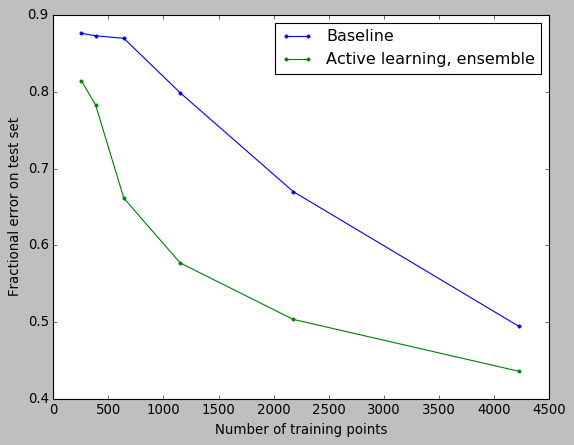

In [10]:
N_train_list = ninit + T * np.array(K_train_list)
plt.style.use("classic")
fig = plt.figure()
plt.plot(N_train_list,frac_err_baseline, ".-", label="Baseline")
plt.plot(N_train_list,frac_err_AL_ens, ".-", label="Active learning, ensemble")
plt.ylabel('Fractional error on test set')
plt.xlabel('Number of training points')
plt.legend()
plt.show()

We can see from this figure that active learning enabled by an uncertainty quantification (such as the ones available with uq360) outperforms sampling at random significantly. For small numbers of training points, the actively learned surrogate has an error significantly smaller than the baseline.